Check Python version

In [177]:
!python --version

Python 3.10.14


Import libraries

In [178]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [179]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [180]:
train_df = pd.read_csv(file_name)

In [181]:
train_df.shape

(144, 2)

In [182]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [183]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [184]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [185]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [186]:
train_df[target_col] = train_df[target_col].astype(float)

In [187]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

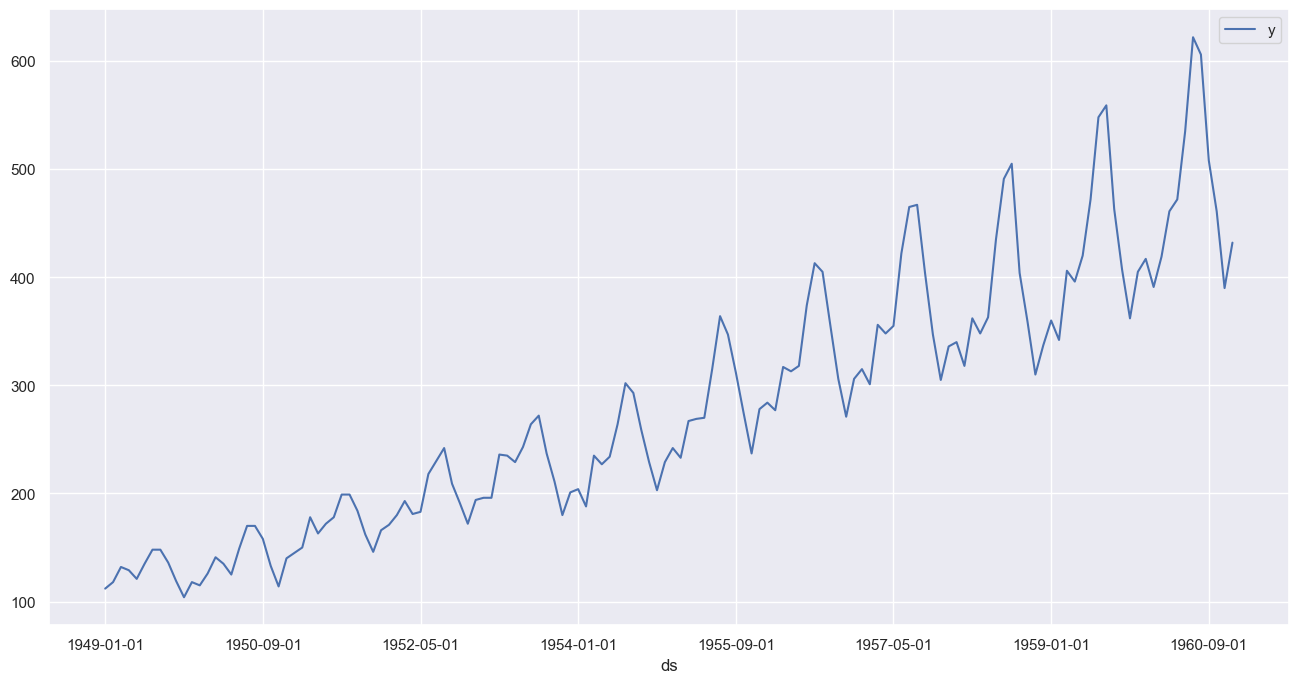

In [188]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [189]:
train_data = []

In [190]:
for value in train_df.values:
    train_data.append(list(value))

In [191]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [192]:
# Default model request
model_request = {
    'type': 'meta_wa',
    'scorers': ['smape', 'mase'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer'},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_naive'},
            {'type': 'darts_seasonalnaive'},
            # {'type': 'darts_autotheta'},
            # {'type': 'darts_autoarima'},
            # {'type': 'darts_autoets'},
        ],
    },
}

# # Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# # np_external_model_request = None

# user_value = 0.9
# output_type = 'data'  # 'data', 'estimate'
# mauq_external_params = {
#     'data': train_df.values.tolist(),
#     'problem_type': 'regression',
#     'confidence_level': user_value,
#     'output_type': output_type

# }

# # Customized model request
# model_request = {
#     'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
#     'scorers': ['mase', 'smape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             # {'type': 'darts_seasonalnaive'},
#             # {'type': 'darts_autotheta'},
#             # {'type': 'stats_autotheta'},
#             # {'type': 'darts_autoets'},
#             # {'type': 'stats_autoets'},
#             # {'type': 'darts_autoarima'},
#             # {'type': 'stats_autoarima'},
#             # {'type': 'darts_autoces'},
#             # {'type': 'darts_kalman'},
#             # {'type': 'darts_catboost'},            
#             # # {'type': 'darts_tbats'},
#             # # {'type': 'darts_linearregression'},
#             # {'type': 'darts_lightgbm',
#             #  'params': {
#             #      'lags': 12,
#             #      'output_chunk_length': 6,
#             #      'verbose': -1
#             # }}
#             # {'type': 'neuralprophet',
#             #  'external_params': np_external_model_request
#             # }  # Onboard NeuralProphet external service
#         ],
#         'mauq_params':[
#             mauq_external_params
#         ]
#     },
# }

This is for JSON model_request

In [193]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [194]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

Train API JSON Payload

In [195]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

In [196]:
api_json['model']

{'type': 'meta_wa',
 'scorers': ['smape', 'mase'],
 'params': {'preprocessors': [{'type': 'dartsimputer'},
   {'type': 'minmaxscaler'}],
  'base_models': [{'type': 'darts_seasonalnaive'}]}}

Build URL

In [197]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [198]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [199]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [200]:
# %%time
# print("Hello")
response = requests.post(url, json=api_json)
# print(response)
# print()

In [201]:
train_json_out = response.json()  # dict output
train_json_out
# response.json()
estimate=train_json_out['estimate']

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [202]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [203]:
model = train_json_out['model']

Forecast API JSON Payload

In [204]:
api_json = {
    'model': model,
    'data': dates,
    'estimate' : estimate
}

Build URL (same as train except for the endpoint)

In [205]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [206]:
%%time
response = requests.post(url, json=api_json,verify=False)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 4.09 s


In [207]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1961-01-01', 417.0, 349.6, 484.4],
  ['1961-02-01', 391.0, 323.6, 458.4],
  ['1961-03-01', 419.0, 351.6, 486.4],
  ['1961-04-01', 461.0, 393.6, 528.4],
  ['1961-05-01', 472.0, 404.6, 539.4],
  ['1961-06-01', 535.0, 467.6, 602.4],
  ['1961-07-01', 622.0, 554.6, 689.4],
  ['1961-08-01', 606.0, 538.6, 673.4],
  ['1961-09-01', 508.0, 440.6, 575.4],
  ['1961-10-01', 461.0, 393.6, 528.4],
  ['1961-11-01', 390.0, 322.6, 457.4],
  ['1961-12-01', 432.0, 364.6, 499.4],
  ['1962-01-01', 417.0, 349.6, 484.4],
  ['1962-02-01', 391.0, 323.6, 458.4],
  ['1962-03-01', 419.0, 351.6, 486.4],
  ['1962-04-01', 461.0, 393.6, 528.4],
  ['1962-05-01', 472.0, 404.6, 539.4],
  ['1962-06-01', 535.0, 467.6, 602.4],
  ['1962-07-01', 622.0, 554.6, 689.4],
  ['1962-08-01', 606.0, 538.6, 673.4],
  ['1962-09-01', 508.0, 440.6, 575.4],
  ['1962-10-01', 461.0, 393.6, 528.4],
  ['1962-11-01', 390.0, 322.6, 457.4],
  ['1962-12-01', 432.0, 364.6, 499.4]]}

Combine forecast dates and output

In [208]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col,"Lower Bound","Upper Bound"],
)

## Mauq testing

In [209]:
forecast_df.shape

(24, 4)

In [210]:
forecast_df.columns

Index(['ds', 'y', 'Lower Bound', 'Upper Bound'], dtype='object')

In [211]:
forecast_df.head()

,ds,y,Lower Bound,Upper Bound
0,1961-01-01,417.0,349.6,484.4
1,1961-02-01,391.0,323.6,458.4
2,1961-03-01,419.0,351.6,486.4
3,1961-04-01,461.0,393.6,528.4
4,1961-05-01,472.0,404.6,539.4


In [212]:
forecast_df.tail()

,ds,y,Lower Bound,Upper Bound
19,1962-08-01,606.0,538.6,673.4
20,1962-09-01,508.0,440.6,575.4
21,1962-10-01,461.0,393.6,528.4
22,1962-11-01,390.0,322.6,457.4
23,1962-12-01,432.0,364.6,499.4


Plot train and forecast side-by-side

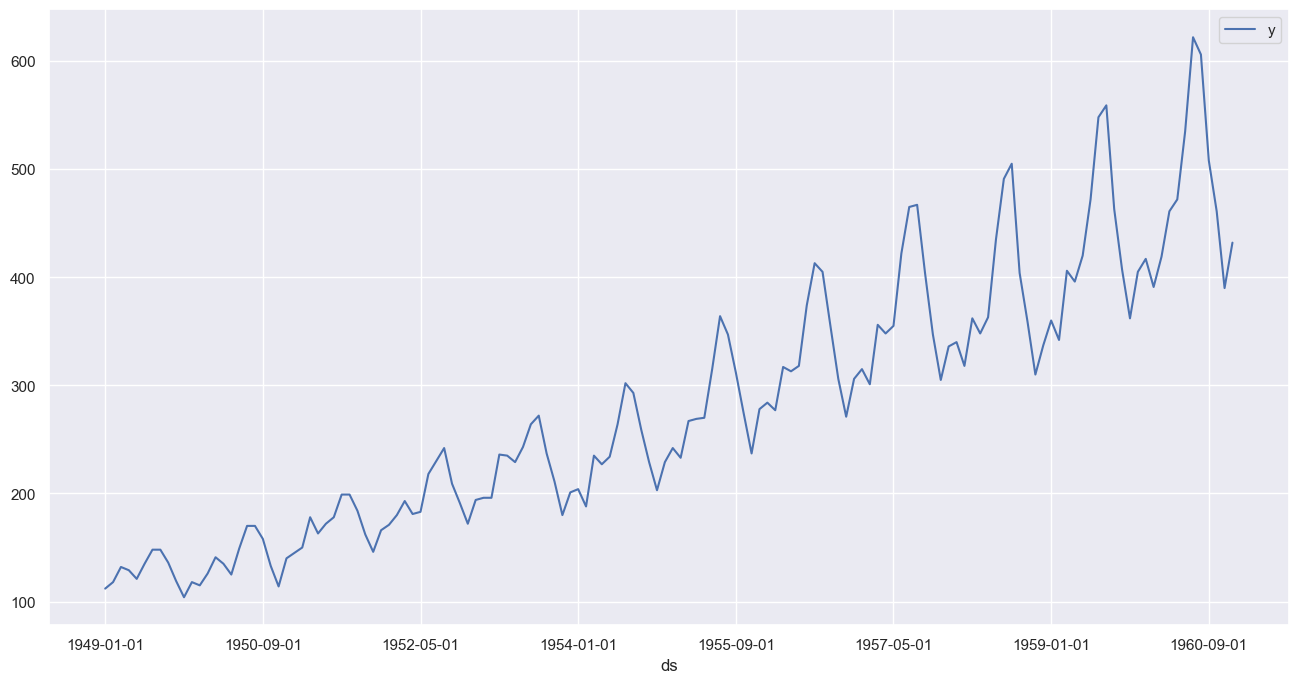

In [213]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

Combine train and forecast sets

In [215]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [216]:
df.shape

(168, 5)

In [217]:
df.head()

,ds,y,color,Lower Bound,Upper Bound
0,1949-01-01,112.0,b,NaN,NaN
1,1949-02-01,118.0,b,NaN,NaN
2,1949-03-01,132.0,b,NaN,NaN
3,1949-04-01,129.0,b,NaN,NaN
4,1949-05-01,121.0,b,NaN,NaN


In [218]:
df.tail()

,ds,y,color,Lower Bound,Upper Bound
163,1962-08-01,606.0,r,538.6,673.4
164,1962-09-01,508.0,r,440.6,575.4
165,1962-10-01,461.0,r,393.6,528.4
166,1962-11-01,390.0,r,322.6,457.4
167,1962-12-01,432.0,r,364.6,499.4


Plot combined train and forecast sets with the vertical black line as the cut-off

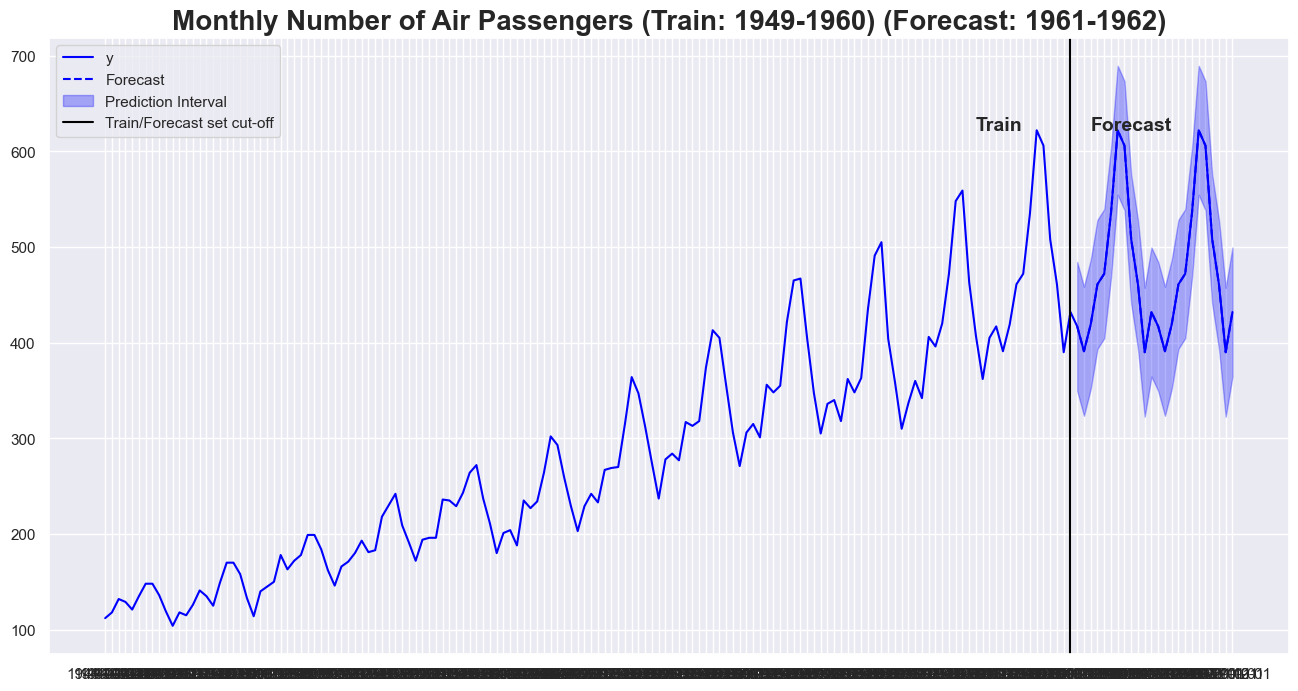

In [225]:
plt.figure(figsize=figsize)

plt.plot(df[time_col], df[target_col], color='blue', label='y')

plt.plot(forecast_df[time_col], forecast_df[target_col], color='blue', linestyle='dashed', label='Forecast')

plt.fill_between(forecast_df[time_col], forecast_df['Lower Bound'], forecast_df['Upper Bound'], 
                 color='blue', alpha=0.3, label='Prediction Interval')

plt.axvline(x=df[time_col].iloc[len(train_df)-1], color='black', label='Train/Forecast set cut-off')

plt.text(df[time_col].iloc[len(train_df)-15], df[target_col].max(), 'Train', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+2], df[target_col].max(), 'Forecast', fontweight='bold', fontsize=14)

plt.title('Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.legend()
plt.show()

